                                    Machine Learning and Computational Statistics, Project
                                      Vasileios Ilias Drouzas, ID: f3352301

In [1]:
import scipy.io as sio
import numpy as np
import scipy.optimize 
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from sklearn import linear_model
from sklearn.linear_model import Ridge
from cvxopt import solvers, matrix
import warnings
warnings.filterwarnings("ignore")                       #Useful for the LASSO case
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.base import BaseEstimator,ClassifierMixin

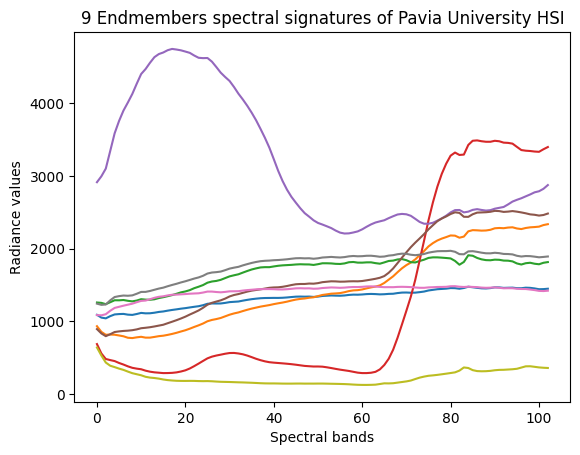

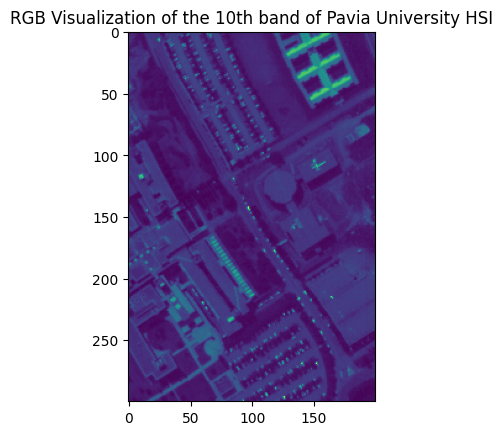

In [2]:
url_path = 'C:/Users/Drogias/OneDrive/Υπολογιστής/MSc Data Science AUEB/1st semester/ML and computational techniques/Assignments/Project/'
Pavia = sio.loadmat(url_path + 'PaviaU_cube.mat')
HSI = Pavia['X']                               #Pavia HSI : 300x200x103
ends = sio.loadmat(url_path + 'PaviaU_endmembers.mat')    # Endmember's matrix: 103x9
endmembers = ends['endmembers']
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

#Perform unmixing for the pixels corresponding to nonzero labels
ground_truth = sio.loadmat(url_path + 'PaviaU_ground_truth.mat')
labels = ground_truth['y']

fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()

*Important note*: Before proceeding to the implementation of the Spectral Unimxing and the Classification, it is important to note that 
we assume our data is following the **normal** distribution. If we do not make sure it happens, a lot of our classifiers would not provide accurate results. In our case, do to the plethora of data given, and recalling the Central Limit Theorem, we can safely assume that our data follow the Gaussian distribution.

<font size="5">Part 1 (Spectral Unmixing)</font>

In [3]:
#Let's define at first X,y.

X = endmembers
y = HSI
print(y)

[[[ 903  763  658 ... 2988 3036 3045]
  [ 817  937  864 ... 3412 3484 3503]
  [ 811  857  905 ... 2965 2977 2983]
  ...
  [1088 1141 1163 ... 1275 1253 1257]
  [1264 1244 1023 ... 1251 1213 1240]
  [1370 1262 1222 ... 1277 1295 1336]]

 [[1234  967  733 ... 2746 2779 2843]
  [ 740  930  923 ... 2641 2711 2737]
  [1292 1106  923 ... 2314 2364 2389]
  ...
  [1143 1095 1131 ... 1300 1299 1327]
  [1498 1302 1199 ... 1298 1262 1286]
  [ 777  573  844 ... 1292 1316 1340]]

 [[1377 1269  987 ... 2617 2663 2727]
  [1157  953  836 ... 2410 2429 2444]
  [1268 1209  997 ... 2205 2229 2236]
  ...
  [1151 1235 1270 ... 1433 1427 1440]
  [1478 1389 1299 ... 1330 1315 1308]
  [1170 1334 1238 ... 1295 1230 1217]]

 ...

 [[ 649  597  635 ... 2665 2736 2786]
  [ 853  886  718 ... 3476 3573 3594]
  [ 846  584  347 ... 3586 3589 3599]
  ...
  [ 519  436  479 ... 3857 3792 3831]
  [ 744  373  136 ... 3472 3467 3495]
  [ 708  374  518 ... 3461 3498 3575]]

 [[ 617  431  570 ... 2777 2804 2793]
  [ 735  576

Then, we need a function that will calculate the reconstruction error ∥yi − Xθi∥^2.

In [4]:
def reconstruction_error(map):                                        
    error = np.zeros((300,200))
    reconstruct_matrix = np.zeros((300,200,103))
    non_zero_indices = np.nonzero(labels)                             # Find non-zero indices in labels
    
    for i, j in zip(non_zero_indices[0], non_zero_indices[1]):         # Iterate over non-zero indices
        reconstruct_matrix[i,j,:] = np.dot(X, map[i,j,:])              #find reconstruct values 
        error[i,j] = np.linalg.norm(y[i,j,:] - reconstruct_matrix[i,j,:])**2            #calculate the error

    mean_error = error.mean()                                           # take the average
    return mean_error    

Additionally, we will make a function that will plot the 9 abundance maps.

In [5]:
def plot_maps(theta_table):
 
    fig, axes = plt.subplots(9, 1, figsize=(25, 30))  # 9 rows, 1 column
    endmembers = ['Water', 'Trees', 'Asphalt', 'Self-Blocking Bricks', 'Bitumen', 'Tiles', 'Shadows', 'Meadows', 'Bare Soil']
    
    for pos in range(9):
        axis = axes[pos]
        plot_theta = theta_table[:, :, pos]
        axis.imshow(plot_theta)
        axis.set_xlabel(f'Endmember {pos+1}')
        axis.set_title(endmembers[pos])
        

    plt.tight_layout()
    plt.show()

a. **Least Squares** method (by hand, as presented in class).

In [6]:
def LS(X, y):
  
    Xx_inv = np.linalg.inv(X.T.dot(X))
    Xy = X.T.dot(y)

    return Xx_inv.dot(Xy)

In [7]:
theta = np.zeros((300,200,9))                                    # Initialize theta matrix

non_zero_indices = np.nonzero(labels)                             # Find non-zero indices in labels

for i, j in zip(non_zero_indices[0], non_zero_indices[1]):         # Iterate over non-zero indices
    y_row = y[i, j, :].reshape(-1, 1)
    theta[i, j] = LS(X, y_row).flatten()                          # calculate theta values
    
print(theta)


[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 1.84349392 -0.68818953  0.19288145 ...  0.07616182 -0.54733839
   -0.22657422]
  [ 1.18208465 -0.58549665 -0.098473   ...  0.20605316 -0.3359524
    0.62438033]
  [-1.44155406  0.22356296 -0.3085635  ...  0.72162882  1.29672677
    1.35052934]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.80012027 -0.36663451 -0.31165634 ... -0.48684548  1.05510323
    0.16443819]
  [-1.49581368 -0.11533218 -0.37873816 ...  0.98780445  1.2409519
    1.588248  ]
  [ 5.81447901 -0.56364064  0.34990309 ... -0.46867651 -3.12125571
   -2.10104713]]

 [[ 0.          0.          0.        

In [8]:
r_error_LS = reconstruction_error(theta)
print("Reconstruction error: ", r_error_LS)

Reconstruction error:  25397.82373757275


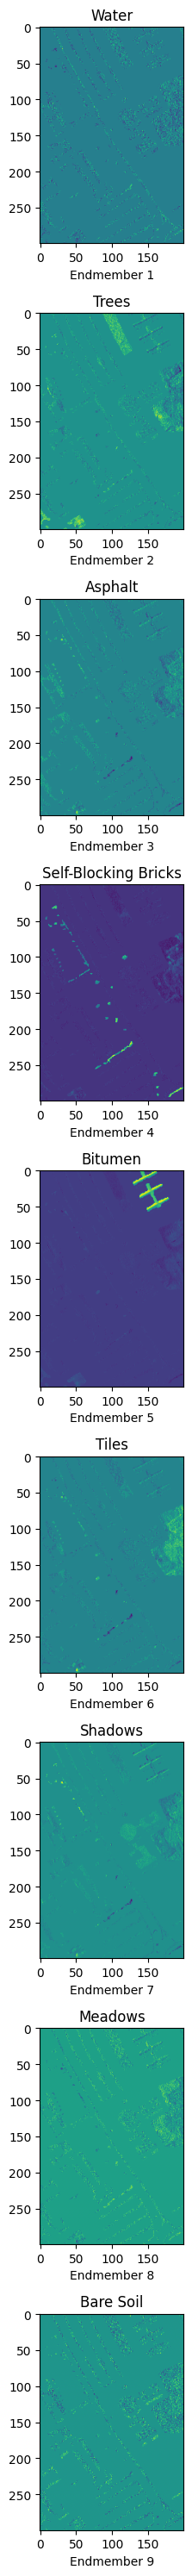

In [9]:
plot_maps(theta)

B. Least squares imposing the **sum-to-one** constraint.

In [10]:
def perform_LS_sum1(X, y):
    model = Ridge(alpha=1.0, fit_intercept=False)  
    model.fit(X, y)
    theta_one_ = model.coef_
    return theta_one_

In [11]:
theta3 = np.zeros((300,200,9))                                    # Initialize theta matrix

non_zero_indices = np.nonzero(labels)                             # Find non-zero indices in labels

for i, j in zip(non_zero_indices[0], non_zero_indices[1]):         # Iterate over non-zero indices
    y_row = y[i, j, :].reshape(-1, 1)
    theta3[i, j] = perform_LS_sum1(X, y_row).flatten()                          # calculate theta values
    
print(theta3)

[[[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 1.84164316 -0.68785087  0.19232676 ...  0.07641923 -0.54567468
   -0.22597524]
  [ 1.18106618 -0.58530052 -0.09876697 ...  0.20619249 -0.33504047
    0.62469888]
  [-1.43927636  0.22315182 -0.30780266 ...  0.72134354  1.29457568
    1.34976645]]

 [[ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  ...
  [ 0.80008524 -0.36665872 -0.31140688 ... -0.48666567  1.05471838
    0.16439165]
  [-1.49350112 -0.11573802 -0.37799511 ...  0.98748709  1.23882459
    1.58747507]
  [ 5.80778917 -0.56243643  0.34780258 ... -0.46778772 -3.11511691
   -2.0988416 ]]

 [[ 0.          0.          0.      

In [12]:
r_error_LS_2 = reconstruction_error(theta3)
print("Reconstruction error: ", r_error_LS_2)

Reconstruction error:  25397.832676451915


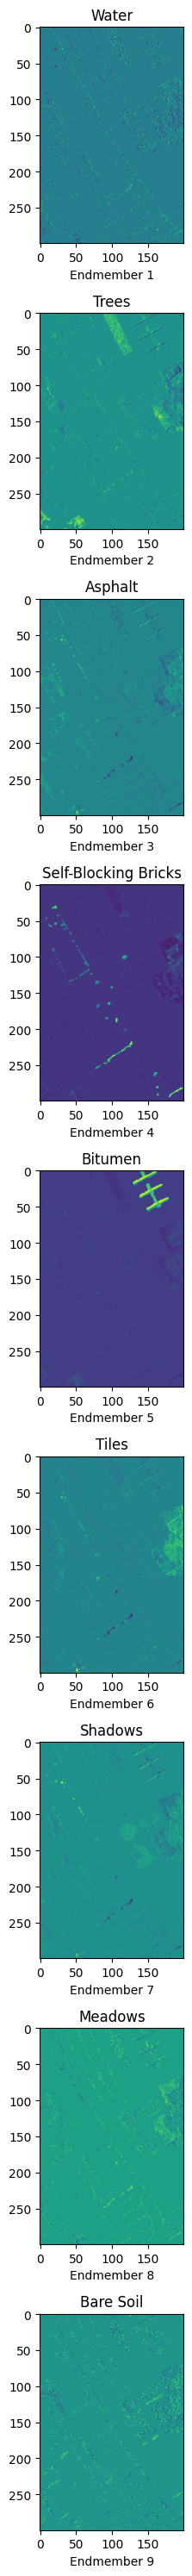

In [13]:
plot_maps(theta3)

C. Least squares imposing the **non-negativity** constraint on the entries of $θ$. 

Note: here we will use the nnls (non-negative least squares) package from scipy-optimize.

In [14]:
theta4 = np.zeros((300,200,9))                                    # Initialize theta matrix

non_zero_indices = np.nonzero(labels)                             # Find non-zero indices in labels

for i, j in zip(non_zero_indices[0], non_zero_indices[1]):         # Iterate over non-zero indices
    theta4[i,j]  = nnls(endmembers, HSI[i,j,:])[0]                 # calculate theta values
    
print(theta4)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.91431632 0.         0.        ]
  [0.         0.         0.         ... 0.8245945  0.         0.34796581]
  [0.         0.         0.05598548 ... 0.72559528 0.         0.51657599]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.01676258 ... 0.95247218 0.         0.        ]
  [0.         0.         0.         ... 0.77959426 0.         0.51178294]
  [0.         0.         0.         ... 0.80029235 0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [15]:
r_error_NNLS = reconstruction_error(theta4)
print("Reconstruction error: ", r_error_NNLS)

Reconstruction error:  121734.22941604616


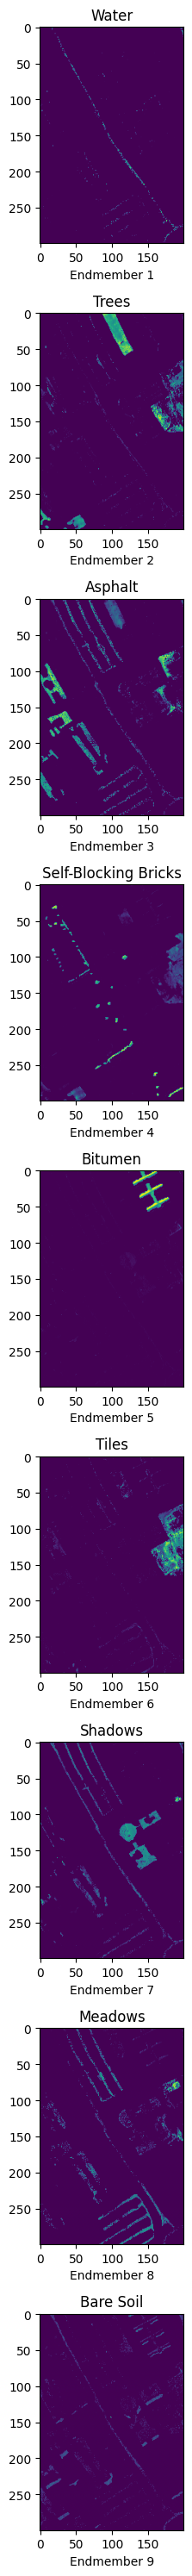

In [16]:
plot_maps(theta4)

D. Least Squares imposing both the **non-negativity** and the **sum-to-one** constraint on the entries of $θ$.

In [17]:
def _numpy_None_concatenate(A1, A2):
    if A1 is None:
        return A2
    else:
        return np.concatenate([A1, A2])

def _numpy_None_vstack(A1, A2):
    if A1 is None:
        return A2
    else:
        return np.vstack([A1, A2])

def _numpy_to_cvxopt_matrix(A):
    
    A = np.array(A, dtype=np.float64)
    if A.ndim == 1:
        return matrix(A, (A.shape[0], 1), 'd')
    else:
        return matrix(A, A.shape, 'd')

def NNLS_constrained_sum_to_one(M, U):
  
    solvers.options['show_progress'] = False
    N, p1 = M.shape
    nvars, p2 = U.shape

    C = _numpy_to_cvxopt_matrix(U.T)
    Q = C.T * C

    lb_A = -np.eye(nvars)
    lb = np.repeat(0, nvars)
    A = _numpy_None_vstack(None, lb_A)
    b = _numpy_None_concatenate(None, -lb)
    A = _numpy_to_cvxopt_matrix(A)
    b = _numpy_to_cvxopt_matrix(b)

    Aeq = _numpy_to_cvxopt_matrix(np.ones((1,nvars)))
    beq = _numpy_to_cvxopt_matrix(np.ones(1))

    M = np.array(M, dtype=np.float64)
    X = np.zeros((N, nvars), dtype=np.float32)
    for n1 in range(N):
        d = matrix(M[n1], (p1, 1), 'd')
        q = - d.T * C
        sol = solvers.qp(Q, q.T, A, b, Aeq, beq, None, None)['x']
        X[n1] = np.array(sol).squeeze()
    return X


In [18]:
theta5 = np.zeros((300,200,9))                                    # Initialize theta matrix

non_zero_indices = np.nonzero(labels)                             # Find non-zero indices in labels

for i, j in zip(non_zero_indices[0], non_zero_indices[1]):         # Iterate over non-zero indices
    y_row = y[i, j, :].reshape(-1,1)
    theta5[i, j] = NNLS_constrained_sum_to_one(y_row.astype(np.double).T, X.astype(np.double).T)                              # calculate theta values
    
print(theta5)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 5.02096100e-06  7.03402179e-07  5.79506668e-05 ...  9.12508726e-01
    5.48495655e-06  6.94482699e-02]
  [ 9.25189170e-08 -4.11013978e-09  1.91160306e-01 ...  5.62459707e-01
    1.06165281e-08  2.18297482e-01]
  [-1.54251616e-08  1.45847032e-08  4.01926756e-01 ...  2.55016774e-01
    3.52669183e-08  3.01170409e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 2.60006431e-07  2.0

In [19]:
r_error_LS_non_neg_sum_one = reconstruction_error(theta5)
print("Reconstruction error: ", r_error_LS_non_neg_sum_one)

Reconstruction error:  973625.6328426679


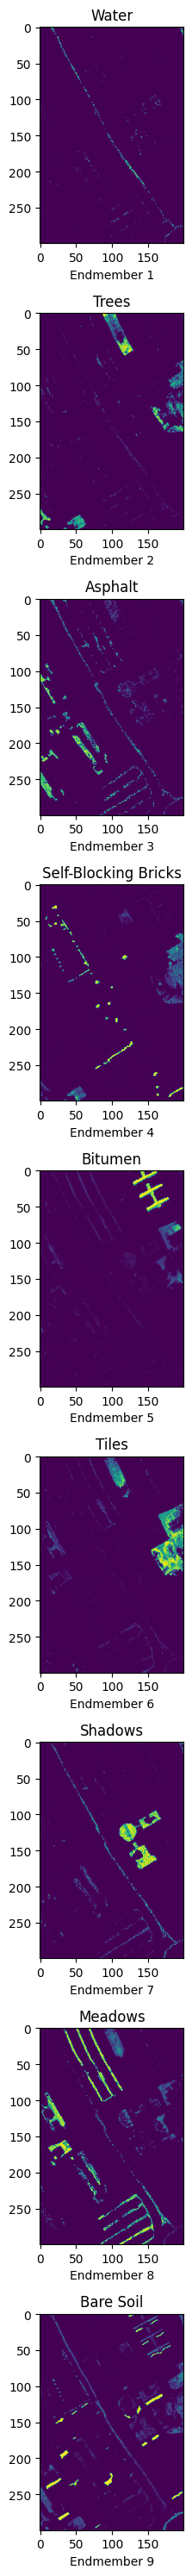

In [20]:
plot_maps(theta5)

E. LASSO, i.e. impose sparsity on $θ$ via $l_1$ norm minimization.

In [21]:
theta6 = np.zeros((300,200,9))                                    # Initialize theta matrix

non_zero_indices = np.nonzero(labels)                             # Find non-zero indices in labels

for i, j in zip(non_zero_indices[0], non_zero_indices[1]):         # Iterate over non-zero indices
    y_row = y[i, j, :].reshape(-1,1)
    lasso_clf = linear_model.Lasso().fit(X, y_row)
    theta6[i,j] = lasso_clf.coef_
    
print(theta6)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 8.95866362e-01 -5.43928008e-01 -4.41175374e-02 ...  1.33053869e-01
    2.20624865e-01 -1.29285640e-02]
  [ 7.02398070e-01 -5.02157723e-01  3.09124393e-02 ...  6.92670466e-01
   -2.88259242e-01  8.88897329e-01]
  [-4.85588880e-01  3.66193117e-03  1.65236173e-01 ...  6.60081584e-01
    1.20245845e-01  9.66084783e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 8.52413596e-01 -4.3

In [22]:
r_error_LASSO = reconstruction_error(theta6)
print("Reconstruction error: ", r_error_LASSO)

Reconstruction error:  38701227.91663479


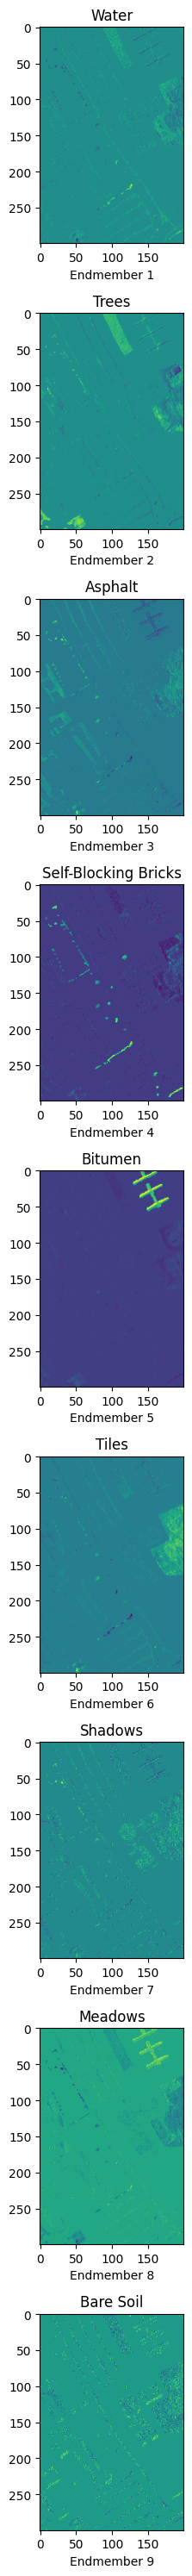

In [23]:
plot_maps(theta6)

In [24]:
def plot_labels(labels):
 
    fig, axes = plt.subplots(9, 1, figsize=(25, 30))  # 9 rows, 1 column
    endmembers = ['Water', 'Trees', 'Asphalt', 'Self-Blocking Bricks', 'Bitumen', 'Tiles', 'Shadows', 'Meadows', 'Bare Soil']
    
    plots = []
    for val in range(1,10):
        label_matrix = np.zeros(labels.shape)
        for i, row in enumerate(labels):
            for j, l in enumerate(row):
                if l == val:
                    label_matrix[i,j] = val
        plots.append(label_matrix)

    for pos in range(9):
        axis = axes[pos]
        plot_labels = plots[pos]
        axis.imshow(plot_labels)
        axis.set_xlabel(f'Label {pos+1}')
        
        

    plt.tight_layout()
    plt.show()

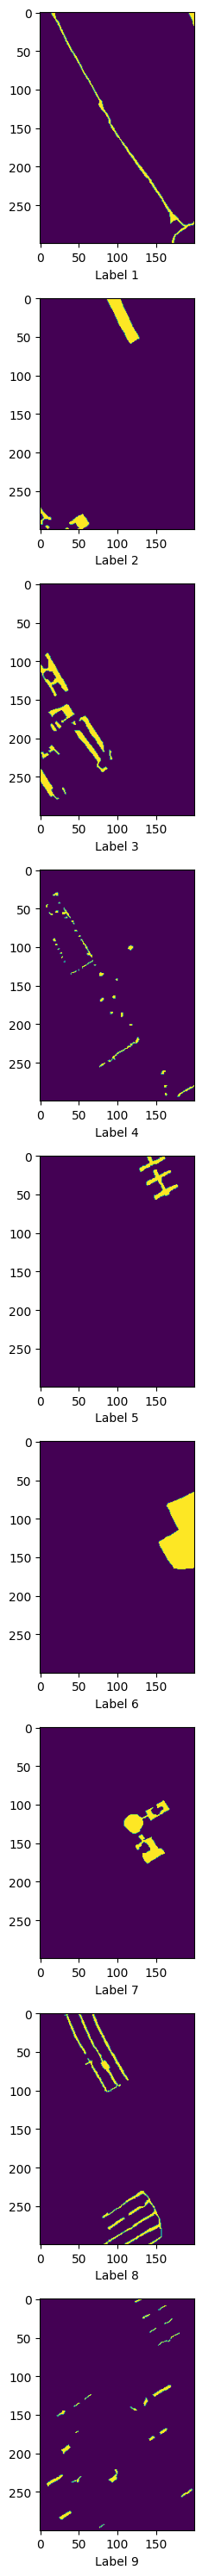

In [25]:
plot_labels(labels)

B. *Comparison based on the abundance maps*. Here, the closest to the ground truth results are achieved by the LS with the non-negative and sum-to-one constraints of $θ$, coming close to the LS with non-negative constraint and the LS with sum-to-one constraint. The rest ML techniques (LS, LASSO) seemed to not perform very well.
1) **LS.** LS on it its own cannot achieve high performance without the assistance of additional constraints. This method does not consider at all crucial aspects of our problem, such as the parameters  of the linear relationship not being negative,,and not weighing the parameters.
2) **LS with non-negativity constraint.** Here, we start constraining the entries of $θ$ with non-negative values, so we expect this method to outperform LS.
3) **LS with sum-to-one constraint.**  Even better here, we normalize the $θ$ values, so perhaps we can expect even better results than the previous method.
4) **LS with non-negativity & sum-to-one constraints.** The best case, since it considers both constraints that are crucial to our problem.
5) **LASSO**. This method apparently does not fit to our problem, becuase the main concept is to put penalties on non-significant $θ$ values. Along with LS, it achieves the worst results..

*Benchmark the reconstruction errors.* The reconstruction errors for each method are the following:

1) **LS:**                                                  25397.82
2) **LS with non-negativity constraint:**                   25397.83
3) **LS with sum-to-one constraint:**                       121734.23
4) **LS with non-negativity & sum-to-one constraints:**     973625.63
5) **LASSO:**                                               38701227.91


Here we see that methods with more constraints show greater reconstruction error values. Possibly this is because the additional constraints try to optimize the endpoints in a way that they remove a bigger amount of noise in the data. This metric is not reliable to benchmark the performance of the classifiers; it aims to show us how much is the difference between the original data (which include noise) and the final data (with reduced noise, according to the case).

<font size="5">Part 2 (Classification) </font>

Text(0.5, 0.2, 'Figure 1: Histograms of the training, test and operational sets.')

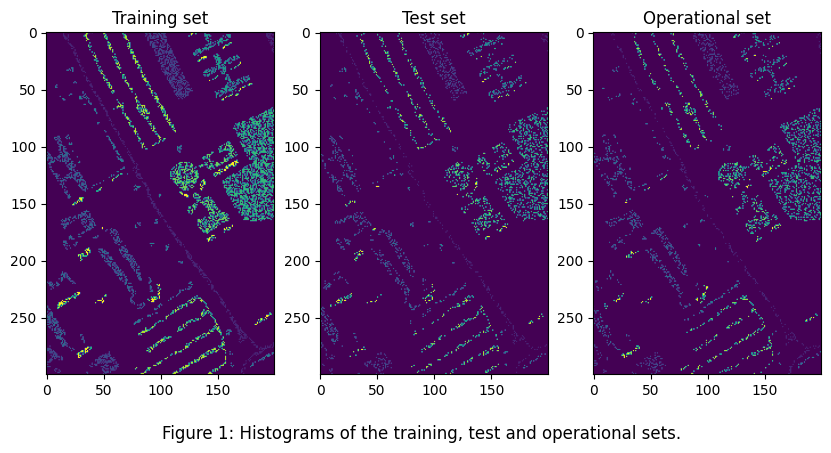

In [26]:
Pavia_labels = sio.loadmat(url_path + 'classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

figure = plt.figure(figsize=(10,8))
axes = figure.subplots(1,3)

axes[0].imshow(Training_Set)
axes[1].imshow(Test_Set)
axes[2].imshow(Operational_Set)
axes[0].set_title('Training set')
axes[1].set_title('Test set')
axes[2].set_title('Operational set')
txt="Figure 1: Histograms of the training, test and operational sets."
plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)

In [27]:
Training_Set

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [28]:
Test_Set

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [29]:
# Define the X_train ,X_test, y_train and y_test values (remember, we consider only pixels with non-zero class label)
X_train = HSI[Training_Set > 0]
y_train = Training_Set[Training_Set > 0]
y_train = y_train.reshape(y_train.shape[0], 1)

X_test = HSI[Test_Set > 0]
y_test = Test_Set[Test_Set > 0]
y_test = y_test.reshape(y_test.shape[0], 1)

X_opt = HSI[Operational_Set > 0]
y_opt = Operational_Set[Operational_Set > 0]
y_opt = y_opt.reshape(y_opt.shape[0],1)

In [30]:
def compute_success_rate(confusion_matrix):                 # Function to compute accuracy of classifier (success rate)
   
    diagonal_sum = np.sum(np.diag(confusion_matrix)) # Sum of diagonal elements (correct predictions)
    
    total_sum = np.sum(confusion_matrix)              # Sum of all elements in the matrix
    
    if total_sum != 0:
        success_rate = diagonal_sum / total_sum
    else:
        success_rate = None
        
    return success_rate

In [31]:
confusion_matrix_labels = {
    "Water", 
    "Trees", 
    "Asphalt", 
    "Self-Blocking Bricks", 
    "Bitumen", 
    "Tiles", 
    "Shadows", 
    "Meadows", 
    "Bare Soil"
}


In [32]:
def plot_confusion_matrix(classifier, x, y):                        # Function to plot the confusion matrix
  
    y_pred = classifier.predict(x)
    
    cm = confusion_matrix(y, y_pred) 
    success_rate = compute_success_rate(cm)
    print(f"Success Rate: {success_rate * 100:.2f}%")
    
    np_labels = np.unique(y)                                        # Get the labels



    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels = confusion_matrix_labels, yticklabels = confusion_matrix_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


A.  Naive Bayes classifier (sk-learn)

In [33]:
#i. 10-fold cross validation
naive_bayes = GaussianNB()
cv_score = cross_val_score(naive_bayes,X_train, y_train, cv=10)
NB_error = 1 - cv_score

error_mean = NB_error.mean()
error_std = NB_error.std()

print("----Naive Bayes----")
print("Mean of error: ", error_mean)
print("Standard Deviation of error: ", error_std)

----Naive Bayes----
Mean of error:  0.35528744514266547
Standard Deviation of error:  0.056764759345350316


Success Rate: 66.01%


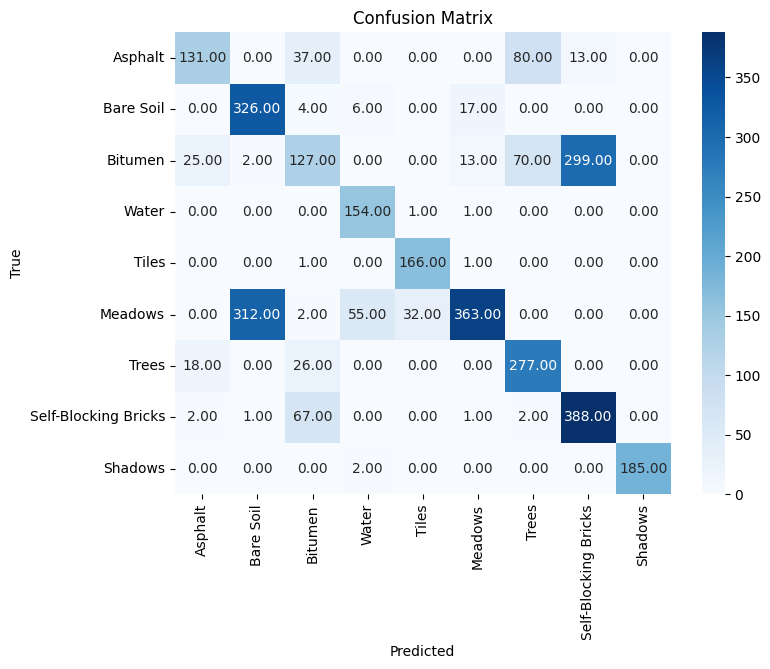

In [34]:
#ii. Evaluate classifier's performance on the test set
naive_bayes.fit(X_train,y_train)
plot_confusion_matrix(naive_bayes,X_test,y_test)
nb_pred = naive_bayes.fit(X_train,y_train).predict(X_test)

B. Minimum Euclidean Distance estimator (custom)

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from sklearn.model_selection import cross_val_score

class MinimumEuclideanDistanceClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.X_train = None
        self.y_train = None
        self.classes_ = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)

    def predict(self, X):
        predictions = []
        for sample in X:
            min_distance = float('inf')
            predicted_class = None
            for idx, train_sample in enumerate(self.X_train):
                distance = np.linalg.norm(sample - train_sample)
                if distance < min_distance:
                    min_distance = distance
                    predicted_class = self.y_train[idx]
            predictions.append(predicted_class)
        return np.array(predictions)


In [36]:
#i. 10-fold cross validation
Euclidean = MinimumEuclideanDistanceClassifier()
cv_score2 = cross_val_score(Euclidean, X_train, y_train, cv=10)
Euclidean_error = 1 - cv_score2

error_mean = Euclidean_error.mean()
error_std = Euclidean_error.std()

print("----Minimum Euclidean Distance Estimator----")
print("Mean of error: ", error_mean)
print("Standard Deviation of error: ", error_std)

----Minimum Euclidean Distance Estimator----
Mean of error:  0.3537441497659906
Standard Deviation of error:  0.08309526790864484


Success Rate: 66.14%


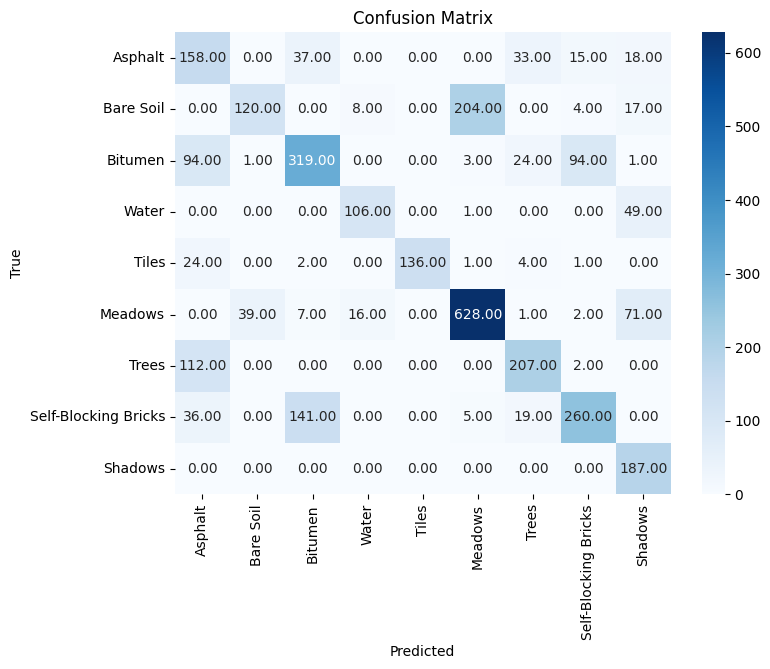

In [37]:
#ii. Evaluate classifier's performance on the test set
Euclidean.fit(X_train,y_train)
plot_confusion_matrix(Euclidean,X_test,y_test)


C. KNN classifier (sk-learn)

In [38]:
#i. 10-fold cross validation
KNN = KNeighborsClassifier(n_neighbors = 3)
cv_score3 = cross_val_score(KNN,X_train, y_train, cv=10)
KNN_error = 1 - cv_score3

error_mean = KNN_error.mean()
error_std = KNN_error.std()

print("----K Nearest neighbors (K = 3)----")
print("Mean of error: ", error_mean)
print("Standard Deviation of error: ", error_std)

----K Nearest neighbors (K = 3)----
Mean of error:  0.15108718367426283
Standard Deviation of error:  0.05049542365566406


Success Rate: 88.65%


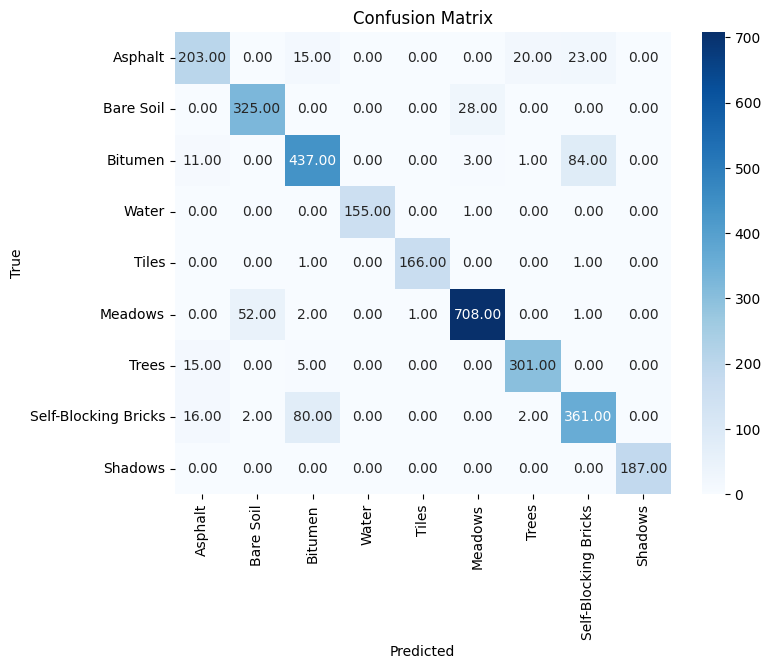

In [39]:
#ii. Evaluate classifier's performance on the test set
KNN.fit(X_train,y_train)
plot_confusion_matrix(KNN,X_test,y_test)
KNN_pred = KNN.fit(X_train,y_train).predict(X_test)

D. Bayes classifier. Here, we will use the Quadratic Disciriminant Analysis ([QDA](https://scikit-learn.org/stable/modules/lda_qda.html)) from sk-learn.

In [40]:
#i. 10-fold cross validation
QDA = QuadraticDiscriminantAnalysis()
cv_score4 = cross_val_score(QDA,X_train, y_train, cv=10)
QDA_error = 1 - cv_score4

error_mean = QDA_error.mean()
error_std = QDA_error.std()

print("----Bayes classifier (QDA)----")
print("Mean of error: ", error_mean)
print("Standard Deviation of error: ", error_std)

----Bayes classifier (QDA)----
Mean of error:  0.14388513858311341
Standard Deviation of error:  0.029031938494833875


Success Rate: 88.43%


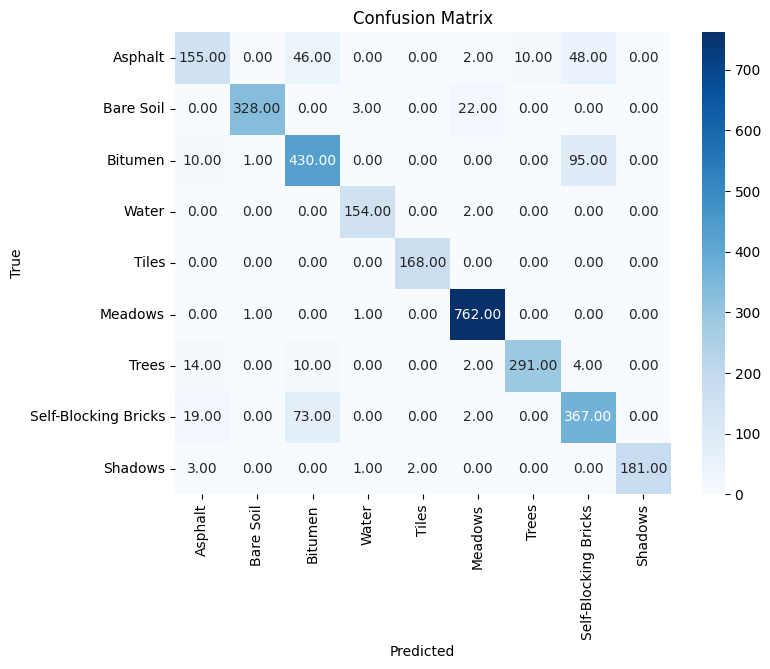

In [41]:
#ii. Evaluate classifier's performance on the test set
QDA.fit(X_train,y_train)
plot_confusion_matrix(QDA,X_test,y_test)
Bayes_pred = QDA.fit(X_train,y_train).predict(X_test)

B. Benchmarking on the classifiers.

The classifiers aim to achieve the best possible separation between the classes, each one trying to optimize the classification according to their own criteria. To understand their performance, we evaluate their accuracy and plot their confusion matrices. Of course, the more diagonal the confusion matrices are, the better our performance of our classifier. Let's break them up one by one:

1) *Naive Bayes* (accuracy **66.01%**). It is clear that NB finds it harsh to separate the classes Tiles and Bitumen. There are also a few mistakes on other classes, like Water and Trees, Tiles and Asphalt (but not to the extent of the first two classes).
2) *Minimum Euclidean Distance Classifier* (accuracy **66.14%**). Achieving similar performance to Naive Bayes, this classifier also has trouble in separating the classes 1. Water and Trees, 2. Bare soil and Shadows, 3. Trees and Shadows.
3) *KNN* (accuracy **88.65%**). This classifier is performing significantly better. The confusion matrix is much more diagonal than the other two cases, with only a little trouble between the classes Water and Trees.
4) *Bayes classifier* (QDA, accuracy **88.43%**). It has similar performance to the KNN classifier. Again here we have a close to diagonal matrix with a little difficulty to distinguish Water and Trees.

In conclusion: KNN and Bayes classifier achieve the best results, while Naive Bayes and our custom implementation of the Minimum Euclidean Distance Classifier fall behind. In Naive Bayes we assume that each 1-dimensional distribution is normal and all features are statistically independent compared to the Bayes classifier. It seems that this case is violated here and we get worst results in Naive Bayes. Finally, about the performance of the minimum euclidean distance, we know that this method assumes the classes are modeled by normal distributions of equaldiagonal covariance matrices, in the form $σ^2$ **Ι**. Falling behind, we expect that this is violated too.  

<font size="5">Part 3 (Combination)</font>

Correlation between Spectral Unmixing and Classification:

1) **Constraints Similarity**: The constraints used in spectral unmixing (like non-negativity and sum-to-one) could have implications in classification. For instance, classifiers that impose restrictions or assumptions similar to those constraints might perform better.
2) **Feature Representation**: The features extracted or manipulated during unmixing could serve as input features for classification. If the unmixing method accurately captures the underlying properties of the data, it could lead to better separability and, in turn, improved classification performance.
3) **Algorithm Robustness**: Algorithms that perform well in spectral unmixing due to their adaptability to constraints or underlying assumptions might also perform better in classification tasks where similar constraints or assumptions apply.

Here, we will take into account the Operation set and compare the results to the predictions of each classifier and the real test data.
(*Note*: We did not consider the Euclidean distance classifier because the basic assumptions do not hold, so the results given by this classifier would not be accurate).

In [42]:
Outcome_NB = (nb_pred == y_opt)
Outcome_KNN = (KNN_pred == y_opt)
Outcome_Bayes = (Bayes_pred == y_opt)
Outcome_data = (y_test == y_opt)

In [43]:
unique1, all1 = np.unique(Outcome_NB, return_counts = True)
unique2, all2 = np.unique(Outcome_KNN, return_counts = True)
unique3, all3 = np.unique(Outcome_Bayes, return_counts = True)
unique4, all4 = np.unique(Outcome_data, return_counts = True)

print("Naive Bayes: ",dict(zip(unique1, all1)))
print("KNN: ", dict(zip(unique2, all2)))
print("Bayes classifier: ", dict(zip(unique3, all3)))
print("Test set vs Operational Set: ", dict(zip(unique4, all4)))

print("\n")
print("Success rates")

print("Naive Bayes: ", np.around((all1[1]/sum(all1))*100,2) , "%")
print("KNN: ", np.around((all2[1]/sum(all2))*100,2), "%")
print("Bayes: ", np.around((all3[1]/sum(all3))*100,2), "%")
print("Test vs operational set: " , np.around((all4[1]/sum(all4))*100,2), "%")

Naive Bayes:  {False: 9022913, True: 1261936}
KNN:  {False: 8826186, True: 1458663}
Bayes classifier:  {False: 8791872, True: 1492977}
Test set vs Operational Set:  {False: 2169, True: 1038}


Success rates
Naive Bayes:  12.27 %
KNN:  14.18 %
Bayes:  14.52 %
Test vs operational set:  32.37 %


Here, we examined the performance of the classifiers on the Operation set. Given that the real success rate of the operational set
lies about 32%, our classifiers fall a bit behind. The best results are given from the Bayesian classifier, followed by the KNN. Naive Bayes has lower accuracy, as expected, given that it holds poor performance for the test set too and the fact that we assume several assumptions (independecy between classes) it holds do not meet.


In general conclusion, from all parts of the project, we assume that spectral information alone is not enough to distinguish points from different classes. Image classification is necessary if we want to have a good insight in our data.  We suggest considering 1) the Least Squares method with both constraints and 2) the KNN and Bayesian classifiers, since they achieve the best results in classification.